<a href="https://colab.research.google.com/github/jardunn/ForTheBirds-EdenToAddo/blob/main/forTheBirds_E2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install Basemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.4/942.4 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 56.1 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.1
    Uninstalling pyproj-3.7.1:
      Successfully uninstalled pyproj-3.7.1
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
from mpl_toolkits.basemap import Basemap
import json
import datetime

#For the birds: The influence of conservation corridors on bird conservation

#Eden to Addo Corridors¶

The area covered by the Eden to Addo Corridor is stored as a shape file. In this section we use the shape file to determine which pentads from SABAP2 are:

1. Contained: The for corners of the pentad fall within the corridor.
2. Overlap: Over 50% of the pentad falls within a [SADAP](https://egis.environment.gov.za/data_egis/data_download/current) protected area.
3. Neighbour: None of the pentad corners fall witin the boundary but the pentad shares at least one side with an Overlapping pentad.



In [2]:
# Read in Eden to Addo Shape Files
e2a_shape_broad_df = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/E2A_Shape/E2A_Broad_Corridors_12Feb2025.shp').to_crs(epsg=4326)
e2a_shape_site_df = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/E2A_Shape/E2A_Sites_12Feb2025.shp')
e2a_shape_df = pd.concat([e2a_shape_broad_df, e2a_shape_site_df])
e2a_shape_df.shape

(14, 16)

In [3]:
# Read in SA Protected Areas Data (SAPAD): https://egis.environment.gov.za/data_egis/data_download/current
SAPAD_shape_df = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/SAPAD_OR_2024_Q3/SAPAD_OR_2024_Q3.shp')
# Remove Noorsveld reserve to rather use the Eden to Addo site
SAPAD_shape_df = SAPAD_shape_df[SAPAD_shape_df.CUR_NME.apply(lambda x: 'Noorsveld' not in x)]
print(f'SAPAD Shape: {SAPAD_shape_df.shape}')


SAPAD Shape: (1663, 11)


In [4]:
# Read in Town Names
with open('/content/drive/MyDrive/ForTheBirds-E2A/SA_map/za.json', 'r') as f:
    town_names = json.load(f)
    f.close()

In [5]:
def inBounds(loc, lower_left, upper_right):
    #print(f'{loc}, ll: ${lower_left}, ur: ${upper_right}')
    return (lower_left[0] <= loc[1] <= upper_right[0]) and (lower_left[1] <= loc[0] <= upper_right[1])

def annotate(text, lat, lon):
    x, y = m(lon, lat)
    plt.text(x, y, text)

def addPlaceNames(places, lower_left, upper_right, population_threshold=None):
    places = [pt for pt in town_names if inBounds((float(pt.get('lat')), float(pt.get('lng'))), lower_left, upper_right)]
    if (population_threshold is not None):
        places = [pt for pt in places if int(pt.get('population', '0')) > population_threshold]
    for place in places:
        annotate(place.get('city'), float(place.get('lat')), float(place.get('lng')))

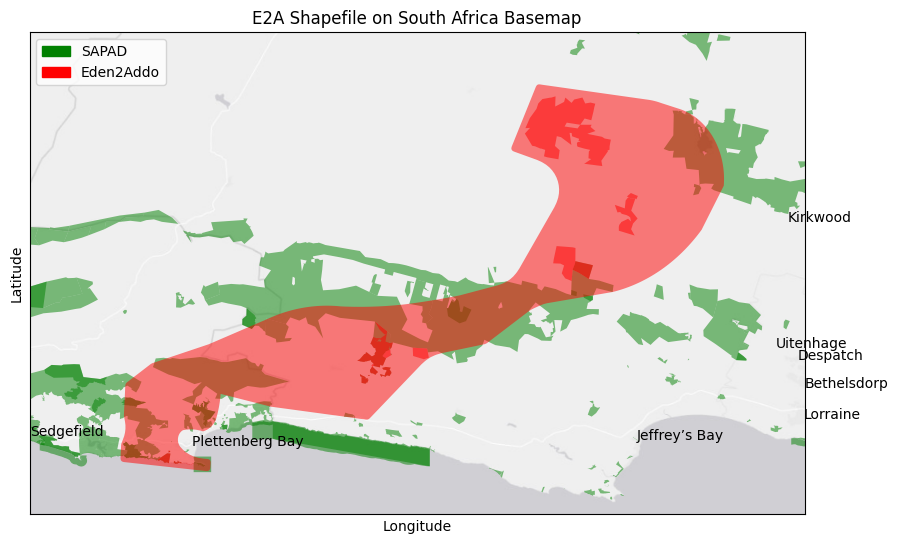

In [6]:
import numpy as np
import geopandas as gpd
from mpl_toolkits.basemap import Basemap

# Assuming e2a_shape_df is already defined as in your previous code

# Define the bounds of South Africa (adjust if needed)
min_lon, min_lat = 22.8, -34.25#20, -34.25#23, -34.25 # approximate min longitude and latitude for South Africa
max_lon, max_lat = 25.5, -32.85#30, -20#25.25, -32.95 # approximate max longitude and latitude for South Africa

# Create the basemap
fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Add coastlines and other map features
#m.drawcoastlines()
#m.drawcountries()
#m.drawmapboundary(fill_color='aqua')
#m.fillcontinents()

# Plot the e2a_shape_df data on the basemap
SAPAD_shape_df.plot(ax=ax, color='green', alpha=0.5) # Plot the shapefile
e2a_shape_df.plot(ax=ax, color='red', alpha=0.5) # Plot the shapefile
#pentad_gdf[pentad_gdf.pentad == '3355_2350'].plot(ax=ax, color='blue')
#pentad_gdf[pentad_gdf.pentad == '3400_2350'].plot(ax=ax, color='orange')

addPlaceNames(town_names, (min_lon, min_lat), (max_lon, max_lat))

# Add a title and labels
plt.title('E2A Shapefile on South Africa Basemap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='green', label='SAPAD')
red_patch = mpatches.Patch(color='red', label='Eden2Addo')
plt.legend(handles=[green_patch, red_patch], loc='upper left')

plt.show()


## Classify Pentads
We want to classify our pentads by first looking at where the corner points lie relative to the border of the borader corridor.

This can be done using the `contains` and `overlaps` Geopandas methods.

In [7]:
# Read in SABAP2 Pentad GeoJson
pentad_gdf = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/SABAP2_geojson.json')
pentad_gdf = pentad_gdf.to_crs(epsg=4326)

In [8]:
pentad_gdf.head()

,pentad,full protocol,full protocol_total_hours,adhoc protocol,incidental,additional information,2007,2008,2009,2010,...,2018,2019,2020,2021,2022,2023,2024,2025,format,geometry
0,0825_3025,1,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,geoJSON,"MULTIPOLYGON (((30.4167 -8.41667, 30.50003 -8...."
1,0900_2900,1,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,geoJSON,"MULTIPOLYGON (((29 -9, 29.08333 -9, 29.08333 -..."
2,0900_3125,1,7,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,geoJSON,"MULTIPOLYGON (((31.4167 -9, 31.50003 -9, 31.50..."
3,0920_2840,2,6,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,geoJSON,"MULTIPOLYGON (((28.6667 -9.33333, 28.75003 -9...."
4,0930_2840,1,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,geoJSON,"MULTIPOLYGON (((28.6667 -9.5, 28.75003 -9.5, 2..."


In [9]:
# Decrease shapes to consider by filtering to coarse bounding box
def filter_to_bounding_box(df, bounding_box):
    return df[df.geometry.apply(lambda row: (bounding_box.contains(row) or bounding_box.overlaps(row)))]

bounding_box = Polygon([(min_lon, min_lat), (max_lon, min_lat), (max_lon, max_lat), (min_lon, max_lat)])
e2a_SAPAD_df = filter_to_bounding_box(SAPAD_shape_df, bounding_box)
e2a_pentad_gdf = filter_to_bounding_box(pentad_gdf, bounding_box)
corridor_boundary = e2a_shape_broad_df.geometry.iloc[0]

# Create a single area of SAPAD data
e2a_SAPAD_area = e2a_SAPAD_df.dissolve()
# Create a single area of the Eden to Addo sites
e2a_site_area = e2a_shape_site_df.dissolve()

In [10]:
# Classify Pentads
def classify_pentad(pentad_geometry, corridor_boundary, protected_areas):
  '''
  Classify SABAP2 pentads according in relation to the E2A corridor
  '''
  if corridor_boundary.contains(pentad_geometry):
    return 'contained'
  elif corridor_boundary.overlaps(pentad_geometry):
    return 'overlapping'
  else:
    return 'external'

def inc_coordinate(coord, value):
  seconds = int(coord[2:])
  minutes = int(coord[:2])
  new_seconds = seconds + value

  if new_seconds < 0:
    minutes -= 1
  elif seconds + value >= 60:
    minutes += 1
  return f'{minutes}{new_seconds % 60:02d}'

def is_neighbour(pentad_row, pentad_df):
  if pentad_row.corridor_status != 'external':
    return False
  pentad_name = pentad_row.pentad
  lat, lon = pentad_name.split('_')
  # Names for pentads to the North, South, East and West
  adjacent_pentad_names = [
      f'{inc_coordinate(lat, 5)}_{lon}',
      f'{inc_coordinate(lat, -5)}_{lon}',
      f'{lat}_{inc_coordinate(lon, 5)}',
      f'{lat}_{inc_coordinate(lon, -5)}'
  ]

  # Check adjacent pentads
  for adjacent_pentad_name in adjacent_pentad_names:
    adjacent_pentad = pentad_df[pentad_df.pentad == adjacent_pentad_name]
    # Check if the adjacent pentad exists and the corridor status if it exists.
    if adjacent_pentad.shape[0] > 0 and (adjacent_pentad.iloc[0].corridor_status == 'contained' or adjacent_pentad.iloc[0].corridor_status == 'overlapping'):
      return True
  return False

# First Pass: Classify as Internal, Overlapping, or External
e2a_pentad_gdf['corridor_status'] = e2a_pentad_gdf.geometry.apply(lambda row: classify_pentad(row, corridor_boundary, e2a_SAPAD_df))
# Second Pass: Classify as Neighbouring if adjacent to an Internal or Overlapping Pentad
e2a_pentad_gdf['corridor_status'] = e2a_pentad_gdf.apply(lambda row: 'neighbour' if is_neighbour(row, e2a_pentad_gdf) else row.corridor_status, axis=1)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


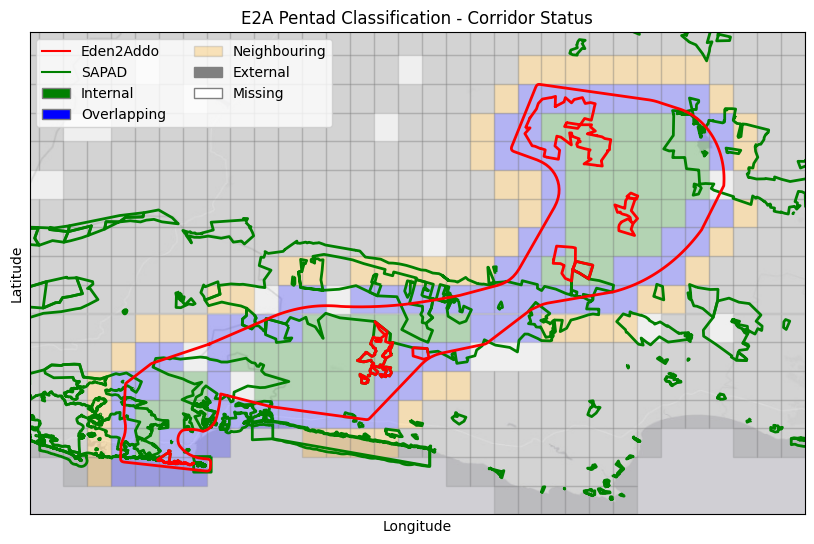

In [11]:
def corridor_colour(corridor_status):
  if corridor_status == 'contained':
    return 'green'
  elif corridor_status == 'overlapping':
    return 'blue'
  elif corridor_status == 'neighbour':
    return 'orange'
  else:
    return 'grey'

fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
e2a_pentad_gdf.plot(ax=ax, color=e2a_pentad_gdf.corridor_status.apply(corridor_colour), edgecolor='grey', alpha=0.25)
e2a_SAPAD_df.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile

# Add a title and labels
plt.title('E2A Pentad Classification - Corridor Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

green_patch = mpatches.Patch(facecolor='green', edgecolor='grey', label='Internal')
blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', label='Overlapping')
orange_patch = mpatches.Patch(facecolor='orange', edgecolor='grey', alpha=0.25, label='Neighbouring')
grey_patch = mpatches.Patch(color='grey', label='External')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', label='Missing')
legend_elements = [red_line, green_line, green_patch, blue_patch, orange_patch, grey_patch, white_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()


## Add Protected Area to Pentads
Use SAPAD regions to mark pentads as protected if they intersect with a protected area.

In [12]:
'''
def classify_protected(pentad_geometry, protected_areas):
  for area in protected_areas:
    if area.overlaps(pentad_geometry).any() or area.contains(pentad_geometry).any():
      return True
  return False

e2a_pentad_gdf['protected'] = e2a_pentad_gdf.geometry.apply(lambda row: classify_protected(row, [e2a_SAPAD_df, e2a_shape_site_df]))
'''
PROTECTED_THRESHOLD = 0.5
e2a_pentad_gdf['protected'] = e2a_pentad_gdf.geometry.apply(
    lambda polygon: (polygon.intersection(e2a_SAPAD_area.geometry.iloc[0]).area + polygon.intersection(e2a_site_area.geometry.loc[0]).area) / polygon.area > PROTECTED_THRESHOLD
)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


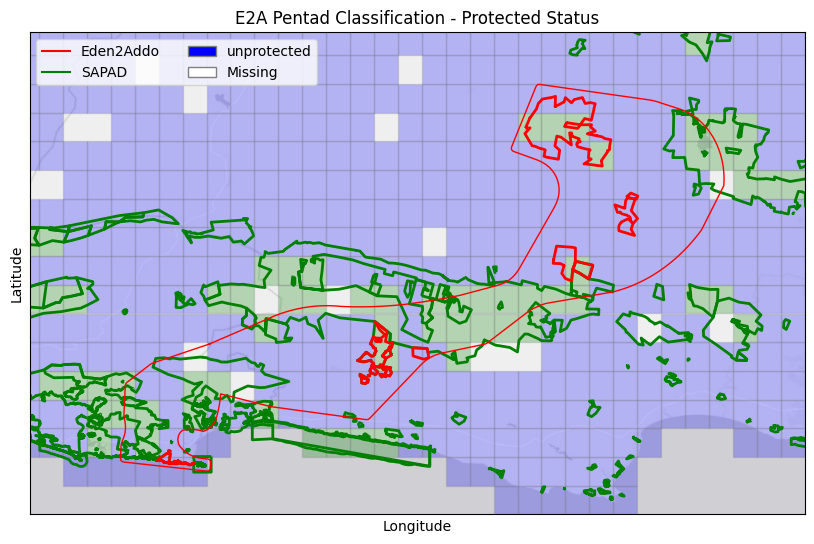

In [13]:
def protected_colour(protected):
  return 'green' if protected else 'blue'

def protected_percentage(percentage, threshold=0.9):
  return 'green' if percentage > threshold else 'blue'

fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
e2a_pentad_gdf.plot(ax=ax, color=e2a_pentad_gdf.protected.apply(protected_colour), edgecolor='grey', alpha=0.25)
e2a_SAPAD_df.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_site_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile
e2a_shape_broad_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=1) # Plot the shapefile

# Add a title and labels
plt.title('E2A Pentad Classification - Protected Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

green_patch = mpatches.Patch(facecolor='green', edgecolor='grey', label='Protected')
blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', label='unprotected')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', label='Missing')
legend_elements = [red_line, green_line, blue_patch, white_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()

# Pentad Statistics

In [14]:
e2a_with_external = e2a_pentad_gdf.copy()
e2a_pentad_gdf = e2a_pentad_gdf[e2a_pentad_gdf.corridor_status != 'external']

In [15]:
e2a_pentad_gdf.groupby('corridor_status').agg({'pentad': 'count','full protocol': sum})

<ipython-input-15-1010d76bf171>:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  e2a_pentad_gdf.groupby('corridor_status').agg({'pentad': 'count','full protocol': sum})


,pentad,full protocol
corridor_status,,
contained,55,605
neighbour,52,1659
overlapping,78,2608


In [16]:
e2a_pentad_gdf[e2a_pentad_gdf.corridor_status != 'external'].groupby('protected').agg({'pentad': 'count', 'full protocol': sum})

<ipython-input-16-e0b18bb4fdbb>:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  e2a_pentad_gdf[e2a_pentad_gdf.corridor_status != 'external'].groupby('protected').agg({'pentad': 'count', 'full protocol': sum})


,pentad,full protocol
protected,,
False,135,3147
True,50,1725


In [17]:
def create_matrix(feature, aggregate_function):
  matrix_data = []

  for protected_status in e2a_pentad_gdf['protected'].unique():
    row = []
    for corridor_status in e2a_pentad_gdf['corridor_status'].unique():
      subset = e2a_pentad_gdf[(e2a_pentad_gdf['protected'] == protected_status) & (e2a_pentad_gdf['corridor_status'] == corridor_status)]
      full_protocol_sum = subset[feature].apply(aggregate_function)
      row.append(full_protocol_sum)
    matrix_data.append(row)

  # Create a DataFrame from the matrix
  matrix_df = pd.DataFrame(matrix_data, index=e2a_pentad_gdf['protected'].unique(), columns=e2a_pentad_gdf['corridor_status'].unique())
  row_totals = matrix_df.sum(axis=1)
  col_totals = matrix_df.sum(axis=0)

  # Add row totals as a new column
  matrix_df['Total'] = row_totals

  # Add column totals as a new row
  matrix_df.loc['Total'] = col_totals

  return matrix_df

print(create_matrix('full protocol', 'sum'))
print(create_matrix('pentad', 'count'))

       neighbour  overlapping  contained   Total
False      414.0       2415.0      318.0  3147.0
True      1245.0        193.0      287.0  1725.0
Total     1659.0       2608.0      605.0     NaN
       neighbour  overlapping  contained  Total
False       39.0         54.0       42.0  135.0
True        13.0         24.0       13.0   50.0
Total       52.0         78.0       55.0    NaN


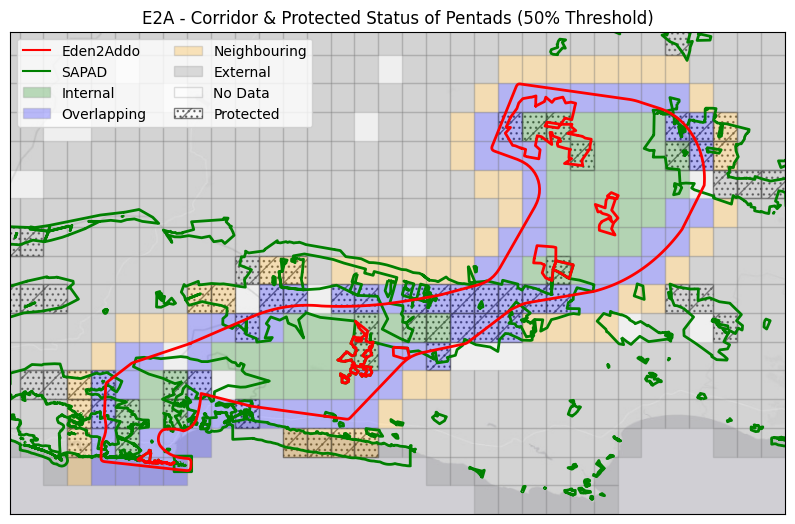

In [18]:
def corridor_colour(corridor_status):
  if corridor_status == 'contained':
    return 'green'
  elif corridor_status == 'overlapping':
    return 'blue'
  elif corridor_status == 'neighbour':
    return 'orange'
  else:
    return 'grey'


fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
# Potected
#e2a_with_external[e2a_with_external.percentage_protected > 0.5].plot(ax=ax, color=e2a_with_external.corridor_status[e2a_with_external.percentage_protected > 0.5].apply(corridor_colour), hatch='/...', edgecolor='grey', alpha=0.25)
#e2a_with_external[e2a_with_external.percentage_protected <= 0.5].plot(ax=ax, color=e2a_with_external.corridor_status[e2a_with_external.percentage_protected <= 0.5].apply(corridor_colour), edgecolor='grey', alpha=0.25)
e2a_with_external[e2a_with_external.protected].plot(ax=ax, facecolor='none', hatch='/...', edgecolor='black', alpha=0.5)
e2a_with_external.plot(ax=ax, color=e2a_with_external.corridor_status.apply(corridor_colour), edgecolor='grey', alpha=0.25)
e2a_SAPAD_area.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile

# Add a title and labels
plt.title('E2A - Corridor & Protected Status of Pentads (50% Threshold)')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

green_patch = mpatches.Patch(facecolor='green', edgecolor='grey', alpha=0.25, label='Internal')
blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', alpha=0.25, label='Overlapping')
orange_patch = mpatches.Patch(facecolor='orange', edgecolor='grey', alpha=0.25, label='Neighbouring')
grey_patch = mpatches.Patch(color='grey', alpha=0.25, label='External')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', alpha=0.25, label='No Data')
hatch_patch = mpatches.Patch(facecolor='white', edgecolor='black', hatch='/...', alpha=0.5, label='Protected')
legend_elements = [red_line, green_line, green_patch, blue_patch, orange_patch, grey_patch, white_patch, hatch_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()

## Get Data from SABAP2
Using the bird map API we will access the species lists for each of the pentads.

In [19]:
# Get list of pentads
pentads = e2a_pentad_gdf.pentad[e2a_pentad_gdf.corridor_status.isin(['contained', 'overlapping', 'neighbour'])].unique()
print(f'Collected {len(pentads)} pentads')


Collected 185 pentads


In [20]:
import requests
from io import StringIO

def getPentadSpeciesList(pentad):
  response = requests.get(f'https://api.birdmap.africa/sabap2/v2/coverage/pentad/{pentad}/species?format=csv')
  pentad_species = pd.read_csv(StringIO(response.text))
  pentad_species['scientific_name'] = pentad_species.apply(lambda row: row.Genus +' '+ row.Species, axis =1 )
  pentad_species['common_name'] = pentad_species.apply(lambda row: (row.Common_species + ' ' +row.Common_group)  if pd.notna(row.Common_group) else row.Common_species, axis = 1)
  pentad_species['pentad'] = pentad
  return pentad_species.drop(columns=['Genus', 'Species', 'Common_species'])



In [21]:
'''
start = datetime.datetime.now()
pentad_species = getPentadSpeciesList(pentads[0])
for pentad in pentads[1:]:
  pentad_species = pd.concat([pentad_species, getPentadSpeciesList(pentad)])
end = datetime.datetime.now()

print(f'Collected from {start} UTC to {end} UTC - {end - start}')
pentad_species.to_csv('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/pentad_species.csv')
'''
#Collected from 2025-02-26 05:08:25.960909 UTC to 2025-02-26 05:11:37.917132 UTC - 0:03:11.956223


"\nstart = datetime.datetime.now()\npentad_species = getPentadSpeciesList(pentads[0])\nfor pentad in pentads[1:]:\n  pentad_species = pd.concat([pentad_species, getPentadSpeciesList(pentad)])\nend = datetime.datetime.now()\n\nprint(f'Collected from {start} UTC to {end} UTC - {end - start}')\npentad_species.to_csv('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/pentad_species.csv')\n"

In [22]:
sabap2_pentad_species = pd.read_csv('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/pentad_species.csv', index_col=0)


In [23]:
sabap2_pentad_species.head()

,Ref,Common_group,fp,fpn,fp_last,ad,adn,ad_last,scientific_name,common_name,pentad
0,637,NaN,100.0,1,2014-01-23,0.0,0,-,Cisticola fulvicapilla,Neddicky,3255_2430
1,622,Apalis,100.0,1,2014-01-23,0.0,0,-,Apalis thoracica,Bar-throated Apalis,3255_2430
2,432,Barbet,100.0,1,2014-01-23,0.0,0,-,Tricholaema leucomelas,Acacia Pied Barbet,3255_2430
3,674,Batis,100.0,1,2014-01-23,0.0,0,-,Batis pririt,Pririt Batis,3255_2430
4,874,Bunting,100.0,1,2014-01-23,0.0,0,-,Emberiza flaviventris,Golden-breasted Bunting,3255_2430


# Read in SABAP2 Data
GBIF.org (19 February 2025) GBIF Occurrence Download https://doi.org/10.15468/dl.gjy4d4

The data is only for the region around the bounded area and includes all records.

In [ ]:
from shapely.geometry import mapping, Polygon
geojson_data = {
    "type": "Feature",
    "geometry": mapping(bounding_box),
    "properties": {}  # You can add properties here if needed
}

# Print the GeoJSON this can be used to extract data from GBIF
print(json.dumps(geojson_data, indent=2))

{
  "type": "Feature",
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          22.8,
          -34.25
        ],
        [
          25.5,
          -34.25
        ],
        [
          25.5,
          -32.85
        ],
        [
          22.8,
          -32.85
        ],
        [
          22.8,
          -34.25
        ]
      ]
    ]
  },
  "properties": {}
}


In [ ]:
sabap_raw_df = pd.read_csv('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/occurrence.txt', sep='\t').dropna(axis=1, how='all').drop(
    columns=['institutionID', 'institutionCode', 'collectionID', 'datasetName', 'ownerInstitutionCode', 'occurrenceID'])

In [ ]:
import re
sabap_raw_df['hours_observing'] = sabap_raw_df.occurrenceRemarks.apply(lambda x: int(re.findall(r'\d+', x)[0]))
print(f'SABAP raw DF shape: {sabap_raw_df.shape}')

SABAP raw DF shape: (691182, 77)


In [ ]:
sabap_df = sabap_raw_df[['verbatimLocality', 'identificationRemarks', 'year', 'month', 'day', 'speciesKey', 'species', 'acceptedScientificName',
       'lastCrawled', 'repatriated', 'fieldNotes', 'hours_observing',
       'isSequenced', 'gbifRegion', 'publishedByGbifRegion', 'level0Gid',
       'level0Name', 'level1Gid', 'level1Name', 'level2Gid', 'level2Name',
       'level3Gid', 'level3Name', 'iucnRedListCategory']].rename(
           columns={
           'verbatimLocality': 'pentad',
           'fieldNotes': 'cardId'
           }
       )

In [ ]:
sabap_df = sabap_df[sabap_df.hours_observing > 1]
print(f'SABAP DF more than 2+ hours shape: {sabap_df.shape}')

SABAP DF more than 2+ hours shape: (618103, 24)


# Merge SABAP2 Data with Pentad Data
Add the `corridor status` and `protected status` to the SABAP2 species data.

In [24]:
# Merge the dataframes
sabap_df = pd.merge(sabap2_pentad_species, e2a_pentad_gdf[['pentad', 'corridor_status', 'protected']], on='pentad', how='left')

In [25]:
sabap_df.head()

,Ref,Common_group,fp,fpn,fp_last,ad,adn,ad_last,scientific_name,common_name,pentad,corridor_status,protected
0,637,NaN,100.0,1,2014-01-23,0.0,0,-,Cisticola fulvicapilla,Neddicky,3255_2430,neighbour,False
1,622,Apalis,100.0,1,2014-01-23,0.0,0,-,Apalis thoracica,Bar-throated Apalis,3255_2430,neighbour,False
2,432,Barbet,100.0,1,2014-01-23,0.0,0,-,Tricholaema leucomelas,Acacia Pied Barbet,3255_2430,neighbour,False
3,674,Batis,100.0,1,2014-01-23,0.0,0,-,Batis pririt,Pririt Batis,3255_2430,neighbour,False
4,874,Bunting,100.0,1,2014-01-23,0.0,0,-,Emberiza flaviventris,Golden-breasted Bunting,3255_2430,neighbour,False


In [26]:
sabap_df.corridor_status.value_counts()

,count
corridor_status,
overlapping,7650
neighbour,5327
contained,4272


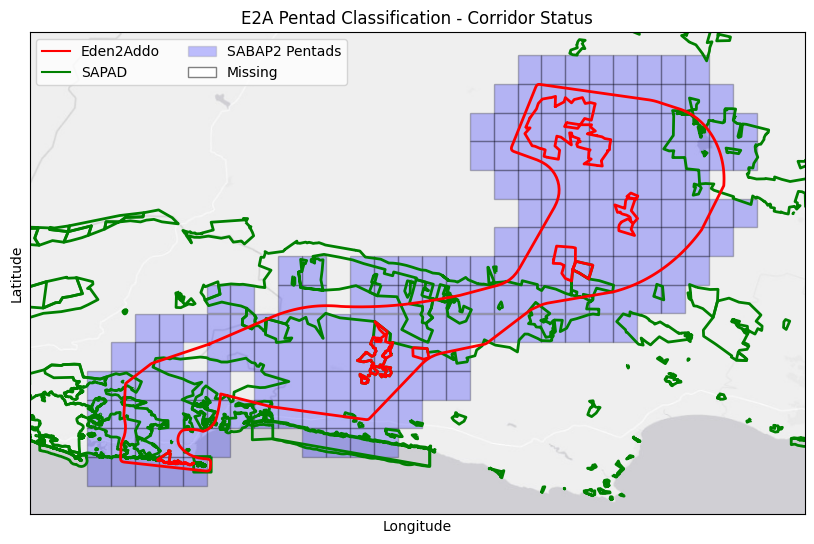

In [27]:
sabap_pentads = pentad_gdf[pentad_gdf.pentad.isin(sabap_df.pentad.unique())]

fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
sabap_pentads.plot(ax=ax, color='blue', edgecolor='black', alpha=0.25)
e2a_SAPAD_df.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile

# Add a title and labels
plt.title('E2A Pentad Classification - Corridor Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', alpha=0.25, label='SABAP2 Pentads')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', label='Missing')
legend_elements = [red_line, green_line, blue_patch, white_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()


## Calculate Reporting Rate
Display the reporting rate for full protocol cards `fp` this is calculated as $\text{Reporting Rate} = \frac{\text{Number  of Species Records}}{\text{Number of Cards}}$

In [28]:
sabap_df['fp_num_cards'] = sabap_df.apply(lambda row: row.fpn / (row.fp / 100) if row.fp else np.nan, axis=1)
sabap_df.head()

,Ref,Common_group,fp,fpn,fp_last,ad,adn,ad_last,scientific_name,common_name,pentad,corridor_status,protected,fp_num_cards
0,637,NaN,100.0,1,2014-01-23,0.0,0,-,Cisticola fulvicapilla,Neddicky,3255_2430,neighbour,False,1.0
1,622,Apalis,100.0,1,2014-01-23,0.0,0,-,Apalis thoracica,Bar-throated Apalis,3255_2430,neighbour,False,1.0
2,432,Barbet,100.0,1,2014-01-23,0.0,0,-,Tricholaema leucomelas,Acacia Pied Barbet,3255_2430,neighbour,False,1.0
3,674,Batis,100.0,1,2014-01-23,0.0,0,-,Batis pririt,Pririt Batis,3255_2430,neighbour,False,1.0
4,874,Bunting,100.0,1,2014-01-23,0.0,0,-,Emberiza flaviventris,Golden-breasted Bunting,3255_2430,neighbour,False,1.0


In [30]:
sabap_df[sabap_df.pentad == '3400_2320']

,Ref,Common_group,fp,fpn,fp_last,ad,adn,ad_last,scientific_name,common_name,pentad,corridor_status,protected,fp_num_cards
15696,722,NaN,8.1708,88,2024-11-15,1.0050,4,2021-12-04,Telophorus zeylonus,Bokmakierie,3400_2320,overlapping,False,1077.005924
15697,72,NaN,2.0427,22,2024-11-16,0.7538,3,2022-04-12,Scopus umbretta,Hamerkop,3400_2320,overlapping,False,1077.005924
15698,1016,NaN,1.1142,12,2019-06-17,0.2513,1,2020-12-27,Anas platyrhynchos,Mallard,3400_2320,overlapping,False,1077.005924
15699,637,NaN,35.2832,380,2025-02-21,6.2814,25,2024-11-28,Cisticola fulvicapilla,Neddicky,3400_2320,overlapping,False,1076.999819
15700,256,NaN,7.6137,82,2024-10-20,3.7688,15,2024-01-07,Calidris pugnax,Ruff,3400_2320,overlapping,False,1077.005924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15994,846,Whydah,30.7335,331,2025-02-15,5.7789,23,2024-12-20,Vidua macroura,Pin-tailed Whydah,3400_2320,overlapping,False,1077.000667
15995,419,Wood Hoopoe,13.7419,148,2025-02-19,5.5276,22,2025-01-19,Phoeniculus purpureus,Green Wood Hoopoe,3400_2320,overlapping,False,1076.998086
15996,450,Woodpecker,3.7140,40,2024-12-20,0.5025,2,2022-09-25,Dendropicos fuscescens,Cardinal Woodpecker,3400_2320,overlapping,False,1077.005924
15997,448,Woodpecker,16.4345,177,2024-12-20,3.5176,14,2024-03-24,Campethera notata,Knysna Woodpecker,3400_2320,overlapping,False,1077.002647


In [135]:
sabap_df[(pd.isna(sabap_df.fp_num_cards)) & (sabap_df.adn > 0)]

,Ref,Common_group,fp,fpn,fp_last,ad,adn,ad_last,scientific_name,common_name,pentad,corridor_status,protected,fp_num_cards
26,524,Raven,0.0,0,-,33.3333,1,2017-08-09,Corvus albicollis,White-necked Raven,3255_2430,neighbour,False,NaN
31,85,Spoonbill,0.0,0,-,33.3333,1,2016-03-08,Platalea alba,African Spoonbill,3255_2430,neighbour,False,NaN
63,523,Crow,0.0,0,-,12.5000,1,2013-08-24,Corvus capensis,Cape Crow,3255_2435,neighbour,False,NaN
68,314,Dove,0.0,0,-,12.5000,1,2019-08-08,Streptopelia semitorquata,Red-eyed Dove,3255_2435,neighbour,False,NaN
71,95,Duck,0.0,0,-,12.5000,1,2017-09-29,Anas sparsa,African Black Duck,3255_2435,neighbour,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17244,4137,Petrel,0.0,0,-,50.0000,1,2021-07-16,Procellaria aequinoctialis,White-chinned Petrel,3405_2305,overlapping,False,NaN
17245,29,Shearwater,0.0,0,-,50.0000,1,2021-07-16,Ardenna grisea,Sooty Shearwater,3405_2305,overlapping,False,NaN
17246,286,Skua,0.0,0,-,50.0000,1,2021-07-16,Stercorarius antarcticus,Subantarctic Skua,3405_2305,overlapping,False,NaN
17247,98,Teal,0.0,0,-,50.0000,1,2021-11-27,Anas capensis,Cape Teal,3405_2305,overlapping,False,NaN


In [32]:
# Aggregate card counts to remove rounding erros
card_count_df = sabap_df[['pentad', 'fp_num_cards']].dropna().groupby('pentad').agg('mean').reset_index()
card_count_df['fp_num_cards'] = card_count_df.fp_num_cards.apply(lambda x: np.round(x))
card_count_df.head()

,pentad,fp_num_cards
0,3255_2430,1.0
1,3255_2435,6.0
2,3255_2440,5.0
3,3255_2445,5.0
4,3255_2450,10.0


In [34]:
def getPentadCardCount(pentad):
  card_count_values = card_count_df[card_count_df.pentad==pentad].fp_num_cards.values
  if len(card_count_values) > 0:
    return card_count_values[0]
  else:
    return 0
sabap_df['fp_num_cards'] = sabap_df.pentad.apply(lambda pentad: getPentadCardCount(pentad))

In [52]:
# get card cound by corridor_status and protected status
# Corridor status and protected to card count df
card_counts_by_status = pd.merge(card_count_df, e2a_pentad_gdf[['pentad', 'corridor_status', 'protected']], on='pentad', how='left').groupby(['corridor_status', 'protected']).agg({'fp_num_cards': 'sum'})

def getCardCountByStatus(corridor_status, protected_status):
  return card_counts_by_status.loc[(corridor_status, protected_status)].fp_num_cards

In [54]:
# Aggregate to corridor_stats and protected
sabap_rr_df = sabap_df.groupby(['scientific_name', 'corridor_status', 'protected']).agg({'fpn': 'sum'}).reset_index()
sabap_rr_df['fp_num_cards'] = sabap_rr_df.apply(lambda row: getCardCountByStatus(row.corridor_status, row.protected), axis=1)
sabap_rr_df['reporting_rate'] = sabap_rr_df.fpn / sabap_rr_df.fp_num_cards
sabap_rr_df.head()

,scientific_name,corridor_status,protected,fpn,fp_num_cards,reporting_rate
0,Accipiter melanoleucus,contained,False,4,318.0,0.012579
1,Accipiter melanoleucus,contained,True,5,289.0,0.017301
2,Accipiter melanoleucus,neighbour,False,9,415.0,0.021687
3,Accipiter melanoleucus,neighbour,True,40,1249.0,0.032026
4,Accipiter melanoleucus,overlapping,False,112,2427.0,0.046148


In [55]:
sabap_rr_df.groupby(['scientific_name', 'corridor_status', 'protected']).agg('count')

fpn  fp_num_cards  \
scientific_name        corridor_status protected                      
Accipiter melanoleucus contained       False        1             1   
                                       True         1             1   
                       neighbour       False        1             1   
                                       True         1             1   
                       overlapping     False        1             1   
...                                               ...           ...   
Zosterops virens       contained       True         1             1   
                       neighbour       False        1             1   
                                       True         1             1   
                       overlapping     False        1             1   
                                       True         1             1   

                                                  reporting_rate  
scientific_name        corridor_status protected                  
Accipiter melanoleucus contained       False                   1  
                                       True                    1  
                       neighbour       False                   1  
                                       True                    1  
                       overlapping     False                   1  
...                                                          ...  
Zosterops virens       contained       True                    1  
                       neighbour       False                   1  
                                       True                    1  
                       overlapping     False                   1  
                                       True                    1  

[1963 rows x 3 columns]

## Read in Eden to Addo Species

In [73]:
e2a_species = pd.read_excel('/content/drive/MyDrive/ForTheBirds-E2A/Corridors all threatened spp list.xlsx', 'birds')\
  .rename(columns={'species.1': 'status'})\
  .drop(columns=['comment'])
e2a_species.head()

,species,status,name
0,Ardeotis kori,NT,Kori bustard
1,Neotis ludwigii,EN,Ludwig’s bustard
2,Neotis denhami,NT,Denham’s bustard
3,Anthropoides paradiseus,VU,Blue crane
4,Turnix hottemtottus,Endemic,Hottentot buttonquail


In [74]:
# Add species
species_to_add = pd.DataFrame({
    'species': ['Aquila verreauxii', 'Polemaetus bellicosus', 'Afrotis afra', 'Ciconia nigra'],
    'satus': ['LC', 'EN', 'VU', 'LC'],
    'name': ["Verreaux's Eagle", 'Martial Eagle', 'Southern Black Korhaan', 'Black Stork']
})
e2a_species = pd.concat([e2a_species, species_to_add])

In [75]:
e2a_species = pd.merge(e2a_species, sabap_rr_df, how='inner', left_on='species', right_on='scientific_name').drop(columns=['scientific_name'])

In [76]:
e2a_species['corridor_status'] = e2a_species.corridor_status.apply(lambda x: 'Internal' if x == 'contained' else x.capitalize())
e2a_species['protected'] = e2a_species.protected.apply(lambda x: 'Protected' if x else 'Unprotected')
e2a_species_RR = e2a_species[['species', 'corridor_status', 'protected', 'reporting_rate']]\
  .pivot(index='species', columns=['corridor_status', 'protected'], values='reporting_rate')\
  .reset_index()\
  .fillna(0)
e2a_species_RR.columns = ['-'.join(col).strip('-') for col in e2a_species_RR.columns]

e2a_species_RR.head()

,species,Internal-Unprotected,Internal-Protected,Neighbour-Unprotected,Overlapping-Unprotected,Overlapping-Protected,Neighbour-Protected
0,Afrotis afra,0.091195,0.010381,0.004819,0.018129,0.035714,0.000000
1,Anthus crenatus,0.040881,0.000000,0.101205,0.007417,0.005102,0.007206
2,Aquila verreauxii,0.106918,0.024221,0.291566,0.017305,0.158163,0.032826
3,Ardeotis kori,0.053459,0.000000,0.028916,0.008653,0.000000,0.000000
4,Buteo trizonatus,0.066038,0.335640,0.040964,0.280181,0.193878,0.240192


In [77]:
def getCommonName(species):
  return e2a_species[e2a_species.species == species].name.values[0]

column_order = ['Internal-Protected', 'Internal-Unprotected', 'Overlapping-Protected',
                'Overlapping-Unprotected', 'Neighbour-Protected', 'Neighbour-Unprotected']

e2a_species_RR['name'] = e2a_species_RR.species.apply(getCommonName)
e2a_species_RR.drop(columns=['species'], inplace=True)
e2a_species_RR = e2a_species_RR[['name'] + column_order]
e2a_species_RR.head()

,name,Internal-Protected,Internal-Unprotected,Overlapping-Protected,Overlapping-Unprotected,Neighbour-Protected,Neighbour-Unprotected
0,Southern Black Korhaan,0.010381,0.091195,0.035714,0.018129,0.000000,0.004819
1,African rock pipit,0.000000,0.040881,0.005102,0.007417,0.007206,0.101205
2,Verreaux's Eagle,0.024221,0.106918,0.158163,0.017305,0.032826,0.291566
3,Kori bustard,0.000000,0.053459,0.000000,0.008653,0.000000,0.028916
4,Forest buzzard,0.335640,0.066038,0.193878,0.280181,0.240192,0.040964


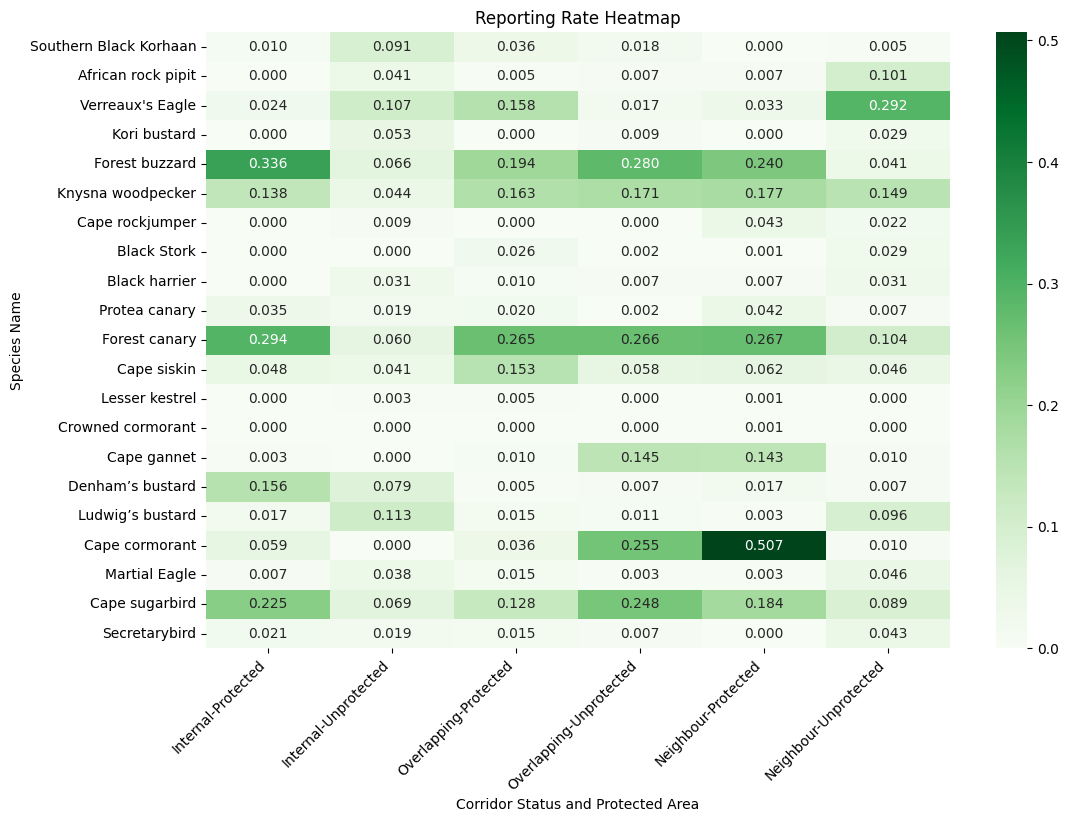

In [78]:
import seaborn as sns

# Assuming e2a_species_RR DataFrame is already created as in your provided code

# Create the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.heatmap(e2a_species_RR.set_index('name'), annot=True, cmap="Greens", fmt=".3f")
plt.title('Reporting Rate Heatmap')
plt.xlabel('Corridor Status and Protected Area')
plt.ylabel('Species Name')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()
